In [11]:
# Packages 
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.integrate import simpson

# Constants
eV = 1.5192678e15
c_ms = 2.99792458e8
nm = 1e-9

# Parameters
t = 20 * nm
omega_0 = 2.0 * eV
lambda_0 = c_ms / omega_0
kp_max = 10 / (20 * nm)
maxeval = 300
medium = "vacuum"

omega_vals = np.linspace(1.2, 3.0, 500) * eV
taus = np.linspace(0, 20e-15, 500)
dt = taus[1] - taus[0]

z_list = [0.05 * lambda_0, 0.1 * lambda_0,  1.0 * lambda_0]
labels = [r"$z = 0.05 \lambda_0$", r"$z = 0.1 \lambda_0$", r"$z = 1.0 \lambda_0$"]

In [8]:
# Dielectric function using the Drude model
def get_eps(w, med):
    """ Returns the dielectric function for a given medium. """
    # Constants
    eb = 9.5
    wp = 9.06 * eV
    g = 0.071 * eV

    if med == "vacuum":
        return 1.0  # Vacuum layer
    elif med == "metal":  # Metal slab (Drude model)
        return eb - (wp**2) / ((w**2) + (1j * w * g))

# Fresnel reflection coefficients for s- and p-polarization
def rij(w, kp, eps1, eps2, pol):
    """ Computes the Fresnel reflection coefficient for given polarization. """
    k = w / c_ms
    kzi = np.sqrt(eps1 * k**2 - kp**2 + 0j)
    kzj = np.sqrt(eps2 * k**2 - kp**2 + 0j)

    if pol == 0:  # s-polarization
        return (kzi - kzj) / (kzi + kzj)
    elif pol == 1:  # p-polarization
        return (eps2 * kzi - eps1 * kzj) / (eps2 * kzi + eps1 * kzj)

# Total reflection coefficient for a metallic slab
def rT(w, kp, eps1, eps2, eps3, t, pol):
    """ Computes the total reflection coefficient for a thin slab. """
    k = w / c_ms
    kz2 = np.sqrt(eps2 * k**2 - kp**2 + 0j)

    r12 = rij(w, kp, eps1, eps2, pol)
    r23 = rij(w, kp, eps2, eps3, pol)

    expid = np.exp(2j * kz2 * t)  # Propagation inside slab
    return (r12 + r23 * expid) / (1 + r12 * r23 * expid)

In [9]:
# Function to compute Gxx using integration
def get_G(w, t, z, kp_max, maxeval, medium):
    """ Computes the xx-component of the Green's function via numerical integration. """
    k = w / c_ms
    imG0 = (2 / 3) * k**3
    eps1 = get_eps(w, "vacuum")  # First medium (vacuum)
    eps2 = get_eps(w, "metal")  # Metal slab
    eps3 = get_eps(w, medium)  # Third medium (vacuum, silica, teflon)

    def fxx(kp):
        """ Integrand function for Gxx calculation (complex-valued). """
        kz = np.sqrt(eps1 * k**2 - kp**2 + 0j)  # Wavevector component in z-direction
        expiz2 = np.exp(2j * kz * z)  # Exponential propagation term
        if np.isclose(kp, np.sqrt(eps1) * k, atol=1e-10):
            return 0
        else:
            return 0.5j * kp * expiz2 / kz * (
                rT(w, kp, eps1, eps2, eps3, t, 0) * k**2
                - rT(w, kp, eps1, eps2, eps3, t, 1) * kz**2
            )
    _, imag_Gxx = 0, spi.quad_vec(lambda kp: np.imag(fxx(kp)), 0, kp_max, limit=maxeval)[0]
    return imag_Gxx / imG0

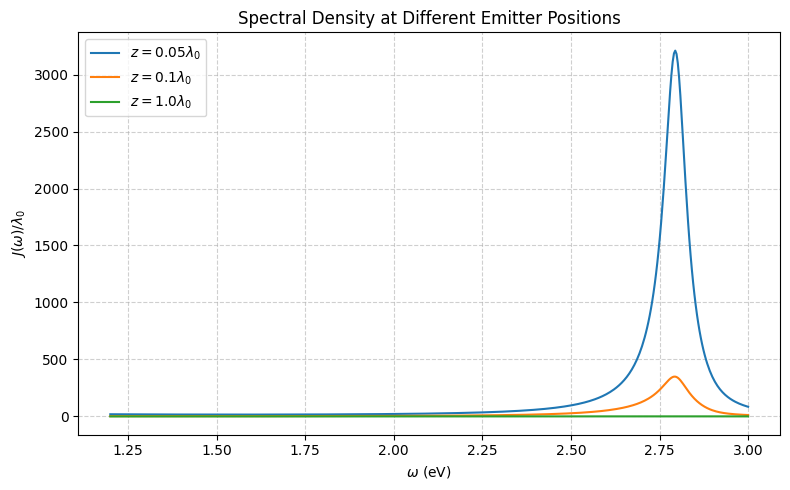

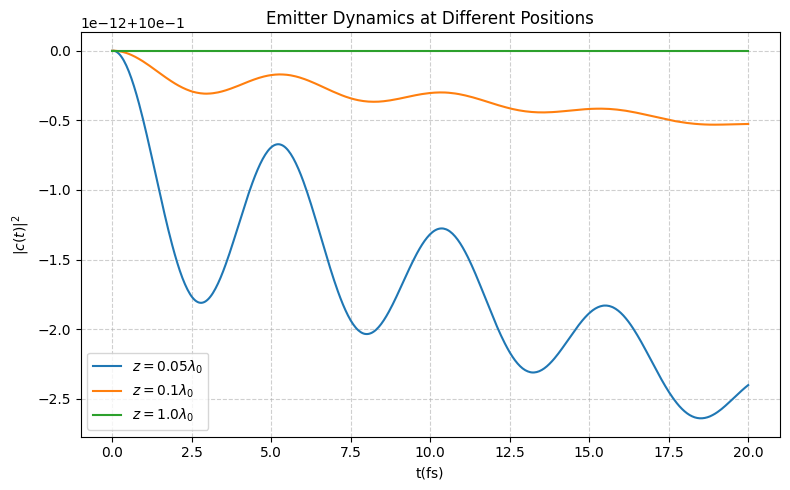

In [10]:
# Plots

plt.figure(figsize=(8, 5))
for z, label in zip(z_list, labels):
    J_vals = np.array([get_G(w, t, z, kp_max, maxeval, medium) for w in omega_vals])
    plt.plot(omega_vals / eV, J_vals, label=label)
plt.xlabel("$\omega$ (eV)")
plt.ylabel("$J(\omega)/\lambda_0$")
plt.title("Spectral Density at Different Emitter Positions")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 5))

for z, label in zip(z_list, labels):
    J_vals = np.array([get_G(w, t, z, kp_max, maxeval, medium) for w in omega_vals])
    f_memory = np.array([
        simpson(J_vals * np.exp(-1j * (omega_vals - omega_0) * tau), omega_vals)
        for tau in taus
    ])
    c_t = np.zeros_like(taus, dtype=complex)
    c_t[0] = 1.0
    for i in range(1, len(taus)):
        tau_grid = taus[:i]
        f_grid = f_memory[1:i+1][::-1]
        c_grid = c_t[:i]
        integral = np.trapezoid(f_grid * c_grid, tau_grid)
        dc_dt = -integral
        c_t[i] = c_t[i-1] + dt * dc_dt

    plt.plot(taus * 1e15, np.abs(c_t)**2, label=label)
plt.xlabel("t(fs)")
plt.ylabel(r"$|c(t)|^2$")
plt.title("Emitter Dynamics at Different Positions")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()